In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [16]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [17]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x
    return poten

In [18]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [19]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =400
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=2
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [20]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [21]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:3.5466601848602295,time:0.06594038009643555,lr:0.01
epoch:10,loss:3.6362929344177246,time:0.6303277015686035,lr:0.01
epoch:20,loss:2.875944137573242,time:1.1775691509246826,lr:0.01
epoch:30,loss:2.3844687938690186,time:1.7253103256225586,lr:0.01
epoch:40,loss:1.988556146621704,time:2.27767276763916,lr:0.01
epoch:50,loss:2.2563862800598145,time:2.825221061706543,lr:0.01
epoch:60,loss:2.0026001930236816,time:3.373676300048828,lr:0.01
epoch:70,loss:1.2991936206817627,time:3.9171037673950195,lr:0.01
epoch:80,loss:0.9201416969299316,time:4.468215703964233,lr:0.01
epoch:90,loss:0.7674922943115234,time:5.016620635986328,lr:0.01
epoch:100,loss:0.6072098016738892,time:5.570612668991089,lr:0.01
epoch:110,loss:0.462502658367157,time:6.121699571609497,lr:0.01
epoch:120,loss:0.4160153269767761,time:6.6711602210998535,lr:0.01
epoch:130,loss:0.7768440842628479,time:7.22292685508728,lr:0.01
epoch:140,loss:0.38651588559150696,time:7.774147033691406,lr:0.01
epoch:150,loss:0.2741190791130066

In [22]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

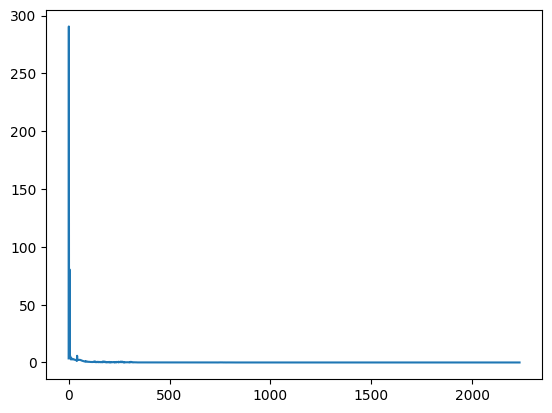

In [23]:
plt.plot(loss_list)
plt.show()

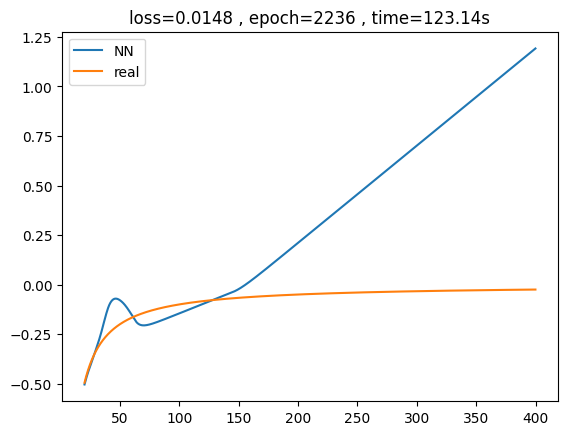

In [24]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


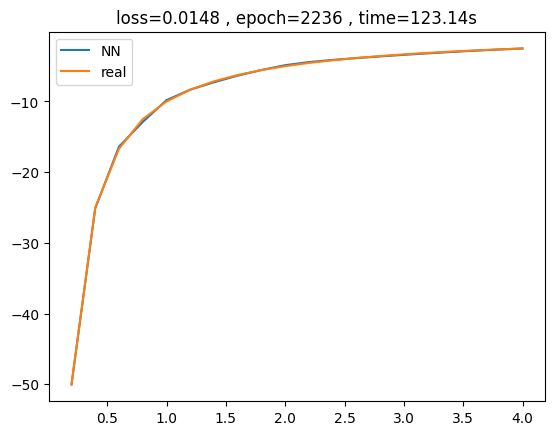

In [30]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [31]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

print('NN energy:')
print(output)
print('real energy:')
print(real_en_list[0])

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

NN energy:
tensor([-30.9102, -10.3568,  -5.0467,  -2.9511,  -1.9078,  -1.3465,  -1.0016,
         -0.7632,  -0.6058,  -0.4960,  -0.4145,  -0.3478,  -0.2871,  -0.2292,
         -0.1948,  -0.1753,  -0.1724,  -0.1582,  -0.1427,  -0.1285,  -0.1180,
         -0.1154,  -0.1031,  -0.0916,  -0.0809,  -0.0737,  -0.0687,  -0.0598,
         -0.0508,  -0.0423], device='cuda:2', grad_fn=<SliceBackward0>)
real energy:
tensor([-30.9102, -10.3569,  -5.0467,  -2.9510,  -1.9259,  -1.3524,  -1.0004,
         -0.7694,  -0.6099,  -0.4951,  -0.4099,  -0.3448,  -0.2941,  -0.2538,
         -0.2212,  -0.1946,  -0.1724,  -0.1538,  -0.1381,  -0.1247,  -0.1131,
         -0.1031,  -0.0943,  -0.0867,  -0.0799,  -0.0739,  -0.0685,  -0.0637,
         -0.0594,  -0.0555], device='cuda:2')
final error: tensor([ 7.6294e-06,  2.5749e-05,  1.4305e-05, -6.0081e-05,  1.8071e-02,
         5.8115e-03, -1.1802e-03,  6.2631e-03,  4.0628e-03, -9.3710e-04,
        -4.6736e-03, -2.9701e-03,  7.0311e-03,  2.4625e-02,  2.6487e-02,
  

energy level while l=0


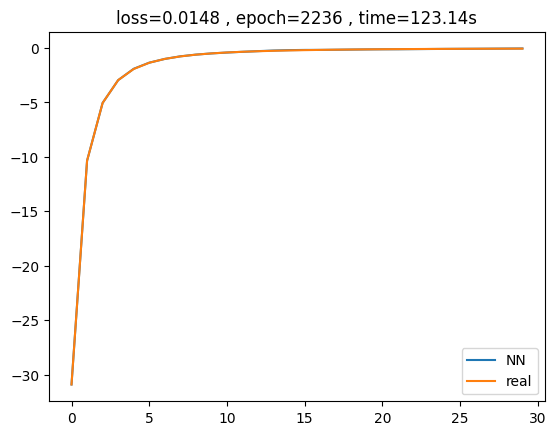

In [27]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

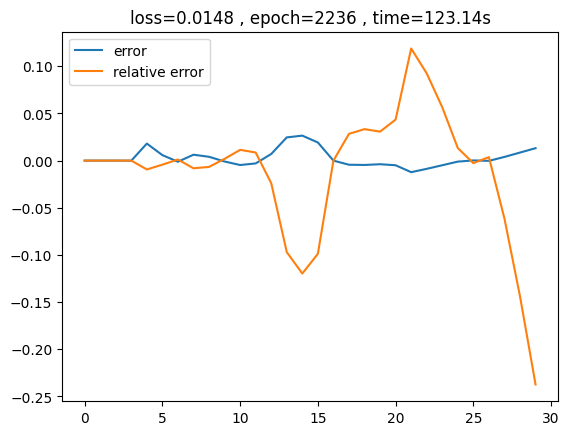

In [28]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()